In [1]:
import os
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import pyloudnorm as pyln
from tqdm import tqdm


In [ ]:
AUDIO_EXTS = {".mp3", ".wav", ".flac", ".m4a", ".aac", ".ogg"}


def find_audio_files(paths: List[str]) -> List[Path]:
    files = []
    for p in paths:
        p = Path(p)
        if p.is_file() and p.suffix.lower() in AUDIO_EXTS:
            files.append(p)
        elif p.is_dir():
            for root, _, filenames in os.walk(p):
                for fn in filenames:
                    if Path(fn).suffix.lower() in AUDIO_EXTS:
                        files.append(Path(root) / fn)
    return sorted(files)


def load_audio(path: Path, target_sr: Optional[int] = None) -> Tuple[np.ndarray, int]:
    """
    Load audio with librosa. Returns float32 in range [-1, 1], shape (n,) mono or (n, ch) stereo collapsed if mono=None.
    We will load in native sr then resample to target_sr if provided (for consistent analysis).
    """
    # librosa loads mono by default (mono=True). To preserve channels, set mono=False and handle later.
    y, sr = librosa.load(str(path), sr=None, mono=False)
    # y shape: (n,) for mono or (ch, n) for multi
    if y.ndim == 1:
        # mono
        if (target_sr is not None) and (sr != target_sr):
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
            sr = target_sr
        return y.astype(np.float32), sr
    else:
        # multi-channel -> keep channels, possible resample per channel
        if (target_sr is not None) and (sr != target_sr):
            y = np.vstack([
                librosa.resample(y[ch], orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
                for ch in range(y.shape[0])
            ])
            sr = target_sr
        return y.astype(np.float32), sr


def to_mono(y: np.ndarray) -> np.ndarray:
    if y.ndim == 1:
        return y
    return np.mean(y, axis=0)


def integrated_lufs(y_mono: np.ndarray, sr: int) -> float:
    meter = pyln.Meter(sr, block_size=0.400)
    return float(meter.integrated_loudness(y_mono))


def short_term_lufs_mean_moving(y_mono: np.ndarray, sr: int, win_sec: float = 3.0, hop_sec: float = 1.0) -> float:
    """
    Short-term LUFS is a mean of loudness measurements in a 3 s window (by default),
    moving every 1 s. Consistent with the EBU R128 ST-LUFS
    """
    meter = pyln.Meter(sr)
    win = int(win_sec * sr)
    hop = int(hop_sec * sr)
    if len(y_mono) < win:
        return np.nan
    vals = []
    for start in range(0, len(y_mono) - win + 1, hop):
        seg = y_mono[start:start+win]
        try:
            l = meter.measure_loudness(seg)
            vals.append(l)
        except Exception:
            continue
    if len(vals) == 0:
        return np.nan
    return float(np.mean(vals))


def loudness_range(y_mono: np.ndarray, sr: int) -> float:
    meter = pyln.Meter(sr, block_size=0.400)
    return float(meter.loudness_range(y_mono))


def true_peak_dbtp(y: np.ndarray, sr: int, oversample: int = 4) -> float:
    """
    Estimate True Peak by oversampling and taking max peak.
    Handles mono or multi-channel; returns max across channels.
    """
    def channel_true_peak(x: np.ndarray) -> float:
        if oversample > 1:
            x_os = librosa.resample(x, orig_sr=sr, target_sr=sr * oversample, res_type="kaiser_best")
        else:
            x_os = x
        tp = np.max(np.abs(x_os))
        # Convert to dBTP (relative to full scale 1.0)
        if tp <= 0:
            return -np.inf
        return 20.0 * np.log10(tp)
    if y.ndim == 1:
        return float(channel_true_peak(y))
    else:
        return float(max(channel_true_peak(y[ch]) for ch in range(y.shape[0])))


def rms_db(y: np.ndarray) -> float:
    # RMS across all channels
    if y.ndim == 1:
        rms = np.sqrt(np.mean(y**2))
    else:
        rms = np.sqrt(np.mean(y**2))
    if rms <= 0:
        return -np.inf
    return 20.0 * np.log10(rms)


def get_channels_count(y: np.ndarray) -> int:
    return 1 if y.ndim == 1 else y.shape[0]


def duration_seconds(y: np.ndarray, sr: int) -> float:
    n_samples = y.shape[-1] if y.ndim > 1 else y.shape[0]
    return float(n_samples / sr)


def audio_info_with_soundfile(path: Path) -> Dict[str, Any]:
    """
    Use soundfile to retrieve container/codec info when possible.
    """
    info = {
        "container": path.suffix.lower().lstrip("."),
        "bit_depth": None,
        "subtype": None,
    }
    try:
        with sf.SoundFile(str(path)) as f:
            info["sample_rate_file"] = int(f.samplerate)
            info["channels_file"] = int(f.channels)
            info["subtype"] = f.subtype
            if f.subtype and "PCM_" in f.subtype:
                try:
                    info["bit_depth"] = int(f.subtype.split("PCM_")[-1])
                except Exception:
                    info["bit_depth"] = None
    except Exception:
        info["sample_rate_file"] = None
        info["channels_file"] = None
    return info


def analyze_file(path: Path, target_sr: Optional[int] = None) -> Dict[str, Any]:
    rec: Dict[str, Any] = {
        "path": str(path),
        "filename": path.name,
        "container": path.suffix.lower().lstrip("."),
        "sample_rate": None,
        "channels": None,
        "duration_s": None,
        "i_lufs": None,
        "s_lufs_mean": None,
        "lra": None,
        "true_peak_dbtp": None,
        "rms_db": None,
        "bit_depth": None,
        "subtype": None,
        "load_error": None,
    }
    file_info = audio_info_with_soundfile(path)
    rec.update({
        "container": file_info.get("container", rec["container"]),
        "bit_depth": file_info.get("bit_depth"),
        "subtype": file_info.get("subtype"),
    })
    try:
        y, sr = load_audio(path, target_sr=target_sr)
        rec["sample_rate"] = int(sr)
        rec["channels"] = int(get_channels_count(y))
        rec["duration_s"] = duration_seconds(y, sr)
        rec["rms_db"] = rms_db(y)
        y_mono = to_mono(y)

        if np.max(np.abs(y_mono)) < 1e-6:
            rec["i_lufs"] = np.nan
            rec["s_lufs_mean"] = np.nan
            rec["lra"] = np.nan
            rec["true_peak_dbtp"] = -np.inf
        else:
            rec["i_lufs"] = integrated_lufs(y_mono, sr)
            rec["s_lufs_mean"] = short_term_lufs_mean_moving(y_mono, sr)
            rec["lra"] = loudness_range(y_mono, sr)
            rec["true_peak_dbtp"] = true_peak_dbtp(y, sr, oversample=4)
    except Exception as e:
        rec["load_error"] = str(e)
    return rec


def analyze_folders(input_paths: List[str], target_sr: Optional[int] = None) -> pd.DataFrame:
    files = find_audio_files(input_paths)
    records: List[Dict[str, Any]] = []
    for fp in tqdm(files, desc="Analyzing audio"):
        rec = analyze_file(fp, target_sr=target_sr)
        records.append(rec)
    df = pd.DataFrame.from_records(records)

    cols = [
        "path", "filename", "container", "subtype", "bit_depth",
        "sample_rate", "channels", "duration_s",
        "i_lufs", "s_lufs_mean", "lra", "true_peak_dbtp", "rms_db",
        "load_error"
    ]
    df = df[cols]
    return df


In [ ]:
INPUTS = [
    "../../Data/FakeRealMusicOriginal"
]

TARGET_SR = None

df = analyze_folders(INPUTS, target_sr=TARGET_SR)

out_csv = "audio_inventory.csv"
df.to_csv(out_csv, index=False)
print(f"Zapisano: {out_csv}")

with pd.option_context('display.max_columns', None, 'display.width', 140):
    print(df.head())
    print("\nStatistics LUFS (without NaN):")
    print(df["i_lufs"].dropna().describe())

Analyzing audio: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]

Zapisano: audio_inventory.csv
                                                path                                           filename container         subtype  \
0  ..\..\Data\FakeRealMusicOriginal\ElevenLabs\1....  1._Ed_Sheeran_-_Perfect_Echoes_of_You_Wariant_...       mp3  MPEG_LAYER_III   
1  ..\..\Data\FakeRealMusicOriginal\ElevenLabs\10...  10._Adele_Rolling_in_the_Deep_-_Edge_of_the_He...       mp3  MPEG_LAYER_III   
2  ..\..\Data\FakeRealMusicOriginal\ElevenLabs\2....  2._Travis_Scott_Sico_Mode_-_Run_This_Town_Wari...       mp3  MPEG_LAYER_III   
3  ..\..\Data\FakeRealMusicOriginal\ElevenLabs\3....  3._Imagine_Dragons_Believer_-_Together_We_Rise...       mp3  MPEG_LAYER_III   
4  ..\..\Data\FakeRealMusicOriginal\ElevenLabs\4....  4._Offset_Bodies_-_Ruckus_Resonance_Wariant_2_...       mp3  MPEG_LAYER_III   

  bit_depth  sample_rate  channels  duration_s     i_lufs  s_lufs_mean   lra true_peak_dbtp     rms_db  \
0      None        44100         2  159.791020 -16.403912        

In [4]:
df.head(5)

,path,filename,container,subtype,bit_depth,sample_rate,channels,duration_s,i_lufs,s_lufs_mean,lra,true_peak_dbtp,rms_db,load_error
0,..\..\Data\FakeRealMusicOriginal\ElevenLabs\1....,1._Ed_Sheeran_-_Perfect_Echoes_of_You_Wariant_...,mp3,MPEG_LAYER_III,None,44100,2,159.791020,-16.403912,NaN,None,None,-15.144875,'Meter' object has no attribute 'loudness_range'
1,..\..\Data\FakeRealMusicOriginal\ElevenLabs\10...,10._Adele_Rolling_in_the_Deep_-_Edge_of_the_He...,mp3,MPEG_LAYER_III,None,44100,2,99.892245,-14.740742,NaN,None,None,-13.552581,'Meter' object has no attribute 'loudness_range'
2,..\..\Data\FakeRealMusicOriginal\ElevenLabs\2....,2._Travis_Scott_Sico_Mode_-_Run_This_Town_Wari...,mp3,MPEG_LAYER_III,None,44100,2,103.888980,-18.108313,NaN,None,None,-14.695863,'Meter' object has no attribute 'loudness_range'
3,..\..\Data\FakeRealMusicOriginal\ElevenLabs\3....,3._Imagine_Dragons_Believer_-_Together_We_Rise...,mp3,MPEG_LAYER_III,None,44100,2,89.887347,-15.715454,NaN,None,None,-14.797494,'Meter' object has no attribute 'loudness_range'
4,..\..\Data\FakeRealMusicOriginal\ElevenLabs\4....,4._Offset_Bodies_-_Ruckus_Resonance_Wariant_2_...,mp3,MPEG_LAYER_III,None,44100,2,73.926531,-16.933697,NaN,None,None,-14.746301,'Meter' object has no attribute 'loudness_range'


Statistics I-LUFS per group:
        group  count       mean       std        min        25%        50%  \
0  ElevenLabs   10.0 -16.000237  1.194929 -18.108313 -16.801251 -15.703553   
1        REAL   10.0 -13.947007  2.756105 -20.351502 -14.866821 -13.824743   
2        SUNO   10.0 -18.994986  0.405355 -19.784920 -19.206815 -18.917793   
3    SUNO_PRO   10.0 -16.133109  1.178736 -17.824721 -16.979826 -15.955463   
4        UDIO   10.0 -16.326972  1.242065 -17.849170 -17.154162 -16.292352   

         75%        max  
0 -15.045186 -14.626448  
1 -11.805199 -11.199401  
2 -18.707654 -18.551256  
3 -15.405993 -14.448095  
4 -16.054417 -13.646127  


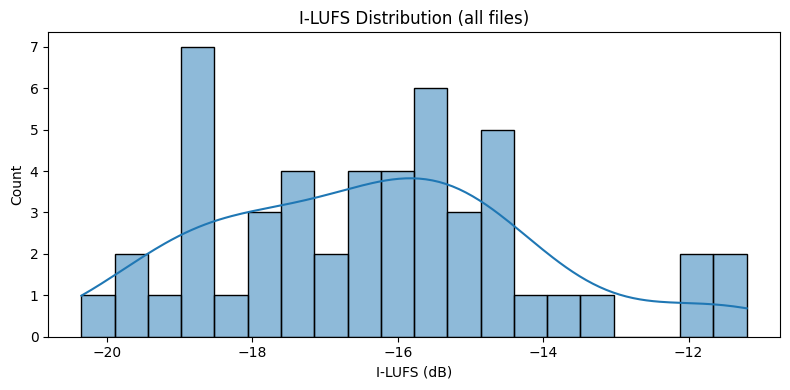

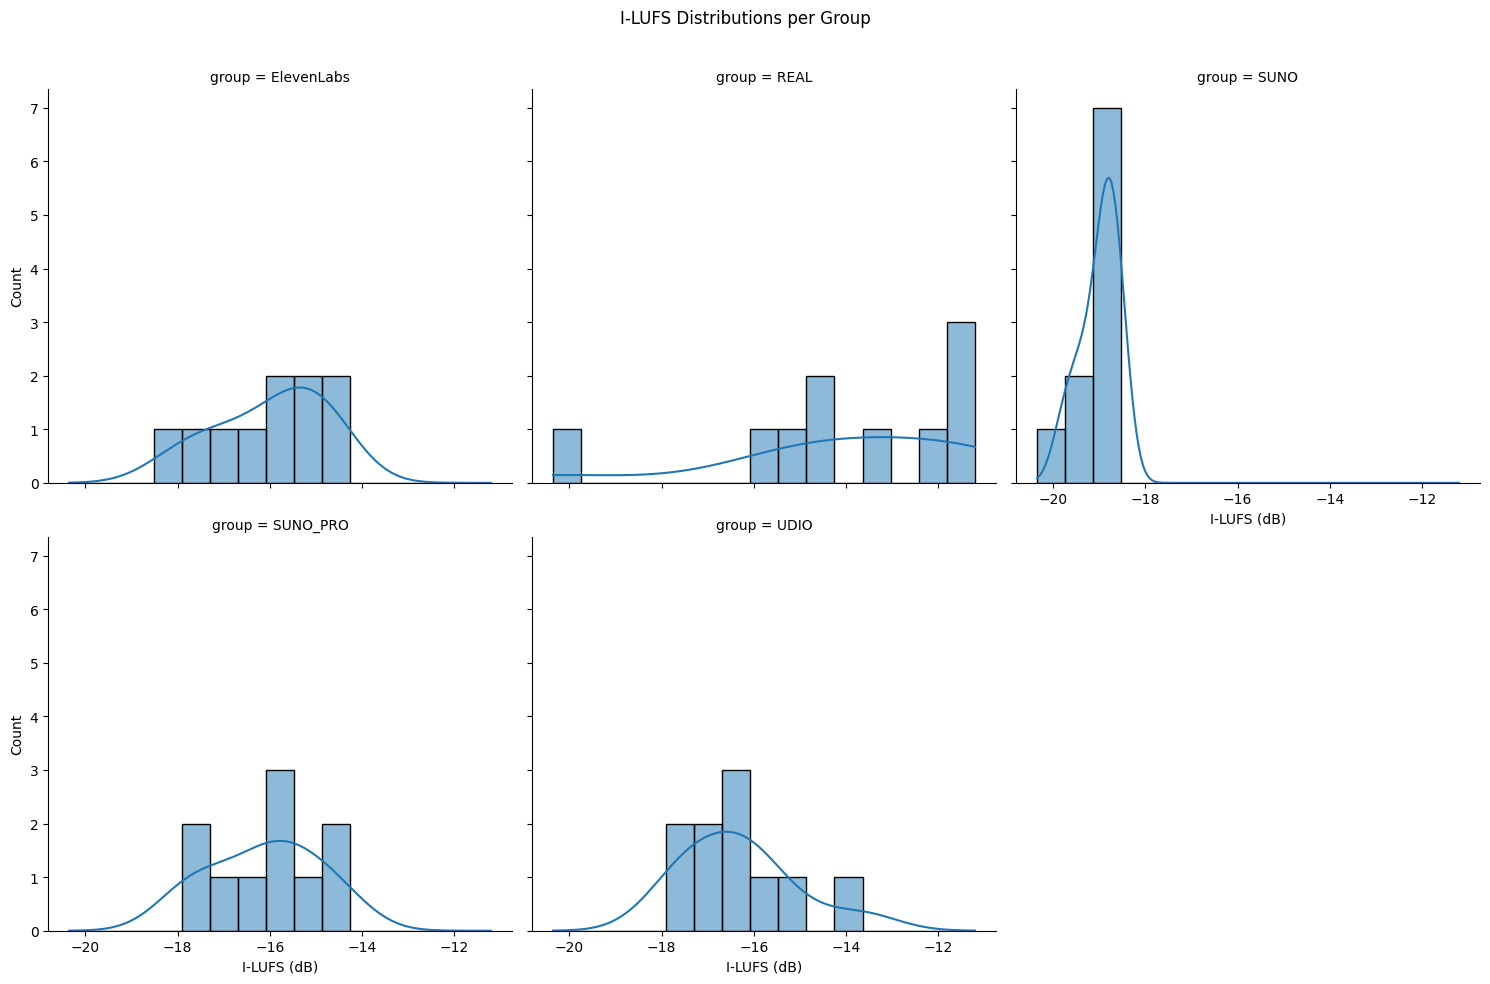

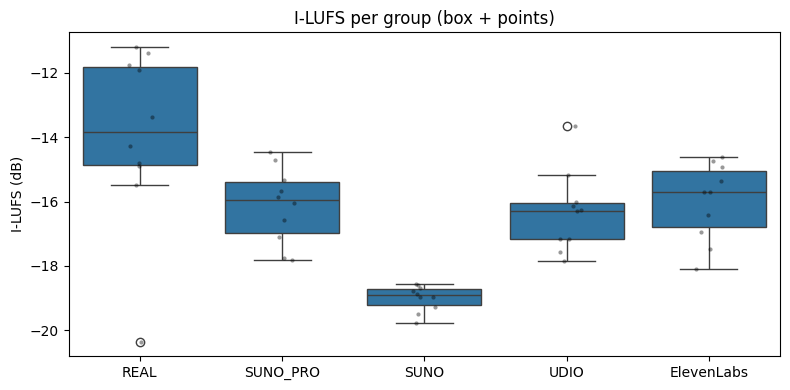

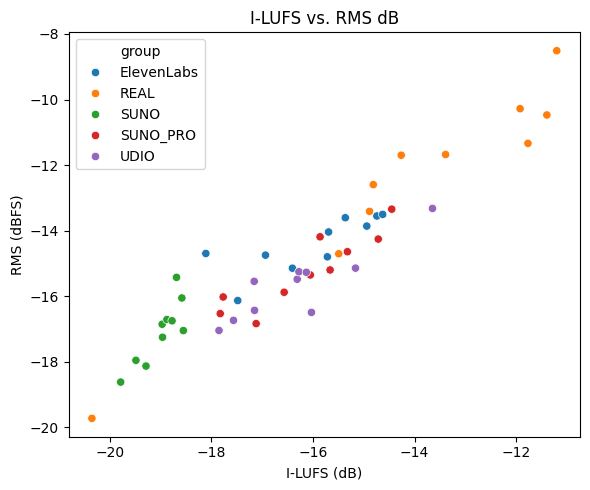

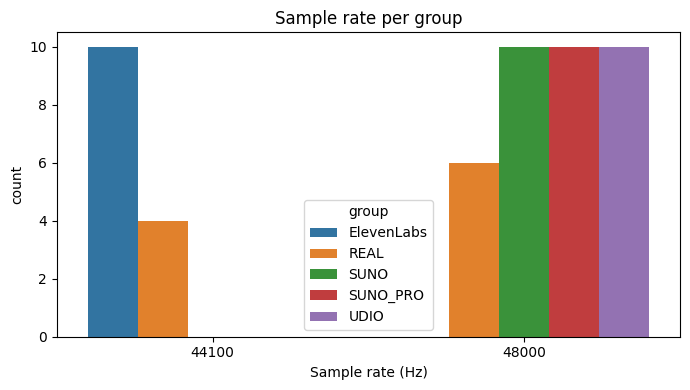

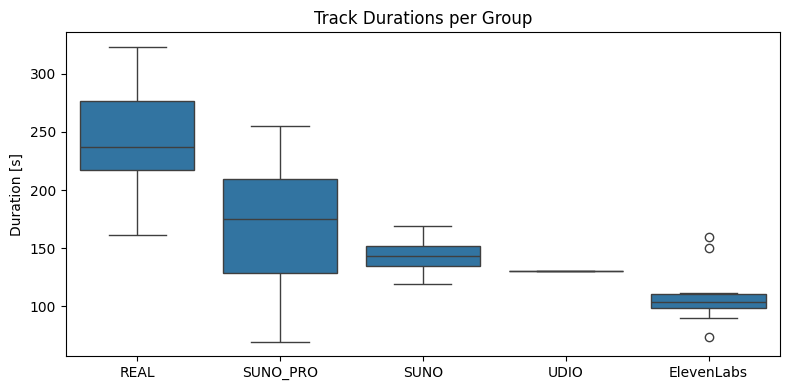

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("audio_inventory.csv")

def infer_group(path):
    path_norm = path.replace("\\", "/").lower()
    if "/real/" in path_norm:
        return "REAL"
    elif "/suno_pro/" in path_norm:
        return "SUNO_PRO"
    elif "/suno/" in path_norm:
        return "SUNO"
    elif "/udio/" in path_norm:
        return "UDIO"
    elif "/elevenlabs/" in path_norm:
        return "ElevenLabs"
    else:

        fn = path_norm.split("/")[-1]
        for g in ["real","suno_pro","suno","udio","elevenlabs"]:
            if g in path_norm or g in fn:
                return g.upper() if g!="elevenlabs" else "ElevenLabs"
        return "UNKNOWN"

df["group"] = df["path"].astype(str).apply(infer_group)

num_cols = ["i_lufs","s_lufs_mean","lra","true_peak_dbtp","rms_db","sample_rate","duration_s"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

stats = df.groupby("group")["i_lufs"].describe().reset_index()
print("Statistics I-LUFS per group:")
print(stats)

# 1) Histogram I-LUFS (all files + facet per group)
plt.figure(figsize=(8,4))
sns.histplot(df["i_lufs"].dropna(), bins=20, kde=True)
plt.title("I-LUFS Distribution (all files)")
plt.xlabel("I-LUFS (dB)")
plt.tight_layout()
plt.show()

g = sns.displot(data=df, x="i_lufs", col="group", col_wrap=3, bins=15, kde=True, facet_kws={'sharex': True, 'sharey': True})
g.set_axis_labels("I-LUFS (dB)", "Count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("I-LUFS Distributions per Group")
plt.show()

# 2) Boxplot I-LUFS per group
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="group", y="i_lufs", order=["REAL","SUNO_PRO","SUNO","UDIO","ElevenLabs"])
sns.stripplot(data=df, x="group", y="i_lufs", color="k", alpha=0.4, size=3, order=["REAL","SUNO_PRO","SUNO","UDIO","ElevenLabs"])
plt.title("I-LUFS per group (box + points)")
plt.ylabel("I-LUFS (dB)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# 3) Scatter: I-LUFS vs RMS (check correlation)
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x="i_lufs", y="rms_db", hue="group")
plt.title("I-LUFS vs. RMS dB")
plt.xlabel("I-LUFS (dB)")
plt.ylabel("RMS (dBFS)")
plt.tight_layout()
plt.show()

# 4) Sample rate distribution per group
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="sample_rate", hue="group")
plt.title("Sample rate per group")
plt.xlabel("Sample rate (Hz)")
plt.tight_layout()
plt.show()

# 5) Additionally: track durations per group
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="group", y="duration_s", order=["REAL","SUNO_PRO","SUNO","UDIO","ElevenLabs"])
plt.title("Track Durations per Group")
plt.ylabel("Duration [s]")
plt.xlabel("")
plt.tight_layout()
plt.show()


### Augmentation Pipeline

## Pipeline przetwarzania i augmentacji audio

### Wejście danych
- Zbiór ok. 50 plików źródłowych w formacie MP3 (różne częstotliwości próbkowania i poziomy głośności). MP3 jest kodekiem stratnym, więc wejście zawiera artefakty kompresji i ograniczenia względem PCM.

### Normalizacja bazowa
- Dla każdego utworu powstają dwie wersje bazowe PCM:
  - minus14/base: normalizacja do −14 LUFS z kontrolą True Peak do ok. −1 dBTP (oversampling x4).
  - minus23/base: normalizacja do −23 LUFS z kontrolą True Peak do ok. −1 dBTP (oversampling x4).
- Jeżeli ustawiono docelowy sample rate (np. 44,1 kHz), sygnał jest resamplowany przed normalizacją.
- Zapis baz w PCM (WAV lub FLAC) z bezpiecznymi nazwami (sanityzacja znaków, zachowanie rdzenia bez starych rozszerzeń).

### Ramiona degradacji (augmentacje)
- Augmentacje są wykonywane na bazowych wersjach PCM i następnie każda wersja jest ponownie normalizowana do −14 LUFS, aby porównania były uczciwe głośnościowo.
- Struktura folderów: minusXX/ramię/GROUP/rel_path/stem.wav, gdzie „minusXX” odpowiada gałęzi bazowej (np. minus14 lub minus23).

#### Lista augmentacji
- minusXX/mp3_192
  - Round‑trip przez MP3 192 kb/s (WAV → MP3 → WAV).
  - Cel: artefakty stratnej kompresji (pre‑echo, maskowanie, „smearing” wysokich tonów).
- minusXX/resample22k
  - Round‑trip resamplingu: sr → 22 050 Hz → sr (wysokiej jakości filtr i rekonstrukcja).
  - Cel: ograniczenie pasma i artefakty filtracji/rekonstrukcji.
- minusXX/noise_snr30
  - Dodanie różowego szumu do docelowego SNR 30 dB względem RMS sygnału.
  - Cel: symulacja tła szumowego, poprawa odporności na zakłócenia.
- minusXX/reverb_room
  - Syntetyczny pogłos (konwolucja z krótką IR, np. RT60 ≈ 0,6 s, mix ≈ 15%).
  - Cel: symulacja akustyki pomieszczenia i rozmycie transjentów.

### Struktura wyjściowa
- OUT_ROOT/
  - minus14/
    - base/GROUP/rel_path/stem.wav
    - mp3_192/GROUP/rel_path/stem.wav
    - resample22k/GROUP/rel_path/stem.wav
    - noise_snr30/GROUP/rel_path/stem.wav
    - reverb_room/GROUP/rel_path/stem.wav
  - minus23/
    - base/GROUP/rel_path/stem.wav
    - mp3_192/…
    - resample22k/…
    - noise_snr30/…
    - reverb_room/…
- Gdzie:
  - `<GROUP>` to grupa wykryta ze ścieżki (np. REAL, SUNO, SUNO_PRO, UDIO, ElevenLabs).
  - `<rel_path>` to relatywna ścieżka pod grupą (zachowanie struktury katalogów).
  - `<stem>` to oczyszczony rdzeń nazwy pliku (bez poprzednich rozszerzeń).

### Co reprezentują dane
- Dane wejściowe: 50 plików MP3 (stratny kodek, artefakty kompresji, zmienny poziom głośności).
- Dane bazowe: referencyjne wersje PCM o wyrównanej głośności (−14 i −23 LUFS) z kontrolą True Peak.
- Dane z augmentacji: kontrolowane warianty baz (kodek MP3, ograniczone pasmo, szum, pogłos), ponownie znormalizowane do −14 LUFS, do trenowania/ewaluacji modeli w warunkach zbliżonych do realnych.

In [ ]:
import os
import subprocess
from pathlib import Path
from typing import List, Optional, Tuple, Dict, Any

import numpy as np
import soundfile as sf
import librosa
import pyloudnorm as pyln
from tqdm import tqdm
import scipy.signal as sig

AUDIO_EXTS = {".mp3", ".wav", ".flac", ".m4a", ".aac", ".ogg"}

# Target levels for "base" material
BASE_TARGETS_LUFS = [-14.0, -23.0]

# After degradations: normalization back to a consistent level (fair comparisons)
POST_DEGRAD_TARGET_LUFS = -14.0

TRUE_PEAK_LIMIT_DBTP = -1.0
OVERSAMPLE_TP = 4

DOC_SR: Optional[int] = 44100  # np. 44100; None = without forcing SR

OUT_FORMAT = "wav"     # "wav" or "flac"
OUT_BIT_DEPTH = 16     # 16 or 24
USE_DITHER_16BIT = True

# Subfolder names
FOLDER_MINUS_PREFIX = "minus"   # minus14, minus23
SUBFOLDER_BASE = "base"

# Enable/disable degradation arms
ENABLE_ARM_MP3_192 = True
ENABLE_ARM_RESAMPLE_22K = True
ENABLE_ARM_NOISE_SNR30 = True
ENABLE_ARM_REVERB_ROOM = True

# Degradation arm parameters
MP3_BITRATE = "192k"    # requires ffmpeg in PATH
RESAMPLE_FREQ = 22050   # Hz (downsample)
NOISE_SNR_DB = 30       # dB (pink noise)
REVERB_RT60 = 0.6       # s
REVERB_MIX = 0.15       # 15%

# Group names detected from paths
KNOWN_GROUPS = ["REAL", "SUNO_PRO", "SUNO", "UDIO", "ElevenLabs"]

def find_audio_files(paths: List[str]) -> List[Path]:
    files = []
    for p in paths:
        p = Path(p)
        if p.is_file() and p.suffix.lower() in AUDIO_EXTS:
            files.append(p)
        elif p.is_dir():
            for root, _, fns in os.walk(p):
                for fn in fns:
                    if Path(fn).suffix.lower() in AUDIO_EXTS:
                        files.append(Path(root) / fn)
    print(f"[INFO] Found {len(files)} audio files.")
    return sorted(files)


def load_audio(path: Path, target_sr: Optional[int] = None) -> Tuple[np.ndarray, int]:
    y, sr = librosa.load(str(path), sr=None, mono=False)
    if (target_sr is not None) and (sr != target_sr):
        if y.ndim == 1:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
        else:
            y = np.vstack([
                librosa.resample(y[ch], orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
                for ch in range(y.shape[0])
            ])
        sr = target_sr
    return y.astype(np.float32), sr

def sanitize_stem_windows(stem: str, max_len: int = 180) -> str:
    bad_chars = '<>:"/\\|?*'
    trans_table = str.maketrans({c: "_" for c in bad_chars})
    safe = stem.translate(trans_table)
    safe = "".join(ch if 32 <= ord(ch) <= 126 else "_" for ch in safe)
    safe = safe.strip().rstrip(" .")
    if len(safe) > max_len:
        half = max_len // 2 - 2
        safe = safe[:half] + "__" + safe[-half:]
    return safe


def save_audio_keep_name(out_dir: Path, original_name: str, y: np.ndarray, sr: int,
                         bit_depth: int, use_dither: bool, fmt: str = "wav") -> Path:
    """
    Save to out_dir with the stem (without previous extensions), sanitized for Windows.
    Final name is constructed explicitly (without .with_suffix).
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    original_stem = Path(original_name).stem

    def strip_invisibles(s: str) -> str:
        invis = ["\u200b", "\u200c", "\u200d", "\ufeff", "\xa0"]
        for ch in invis:
            s = s.replace(ch, " ")
        return " ".join(s.split())

    original_stem = strip_invisibles(original_stem)
    safe_stem = sanitize_stem_windows(original_stem, max_len=180)
    ext = ".wav" if fmt.lower() == "wav" else ".flac"
    out_filename = safe_stem + ext
    out_path = out_dir / out_filename

    data = y if y.ndim == 1 else y.T

    if fmt.lower() == "wav":
        if bit_depth == 16:
            if use_dither:
                data = tpdf_dither(data, bit_depth=16, peak=1.0)
            subtype = "PCM_16"
        else:
            subtype = "PCM_24"
        sf.write(str(out_path), data, sr, subtype=subtype)
    elif fmt.lower() == "flac":
        sf.write(str(out_path), data, sr, format="FLAC")
    else:
        sf.write(str(out_path), data, sr, subtype="PCM_24")

    return out_path


def to_mono(y: np.ndarray) -> np.ndarray:
    return y if y.ndim == 1 else np.mean(y, axis=0)


def integrated_lufs(y_mono: np.ndarray, sr: int) -> float:
    """
    Calculating integrated LUFS for mono signal.
    1) Input: y_mono (mono float signal), sr (sample rate).
    2) Action: uses ITU/EBU compliant meter to compute weighted average loudness.
    3) Returns: LUFS value (negative number; closer to 0 means louder).
    """
    meter = pyln.Meter(sr)
    return float(meter.integrated_loudness(y_mono))


def true_peak_dbtp(y: np.ndarray, sr: int, oversample: int = 4) -> float:
    """
    Estimates True Peak in dBTP with oversampling (default x4).
    - Input: y (mono or multi-channel), sr (sample rate), oversample (oversampling factor).
    - Action: for each channel:
    * optionally oversamples to sr*oversample using high-quality resampling,
    * measures absolute peak,
    * converts to dBFS ⇒ dBTP.
    Returns the maximum across channels.
    - Returns: highest peak value in dBTP; positive values suggest potential clipping after reconstruction
    """
    def ch_tp(x):
        if oversample > 1:
            x_os = librosa.resample(x, orig_sr=sr, target_sr=sr*oversample, res_type="kaiser_best")
        else:
            x_os = x
        p = np.max(np.abs(x_os))
        return -np.inf if p <= 0 else 20*np.log10(p)
    if y.ndim == 1:
        return float(ch_tp(y))
    else:
        return float(max(ch_tp(y[ch]) for ch in range(y.shape[0])))


def apply_gain(y: np.ndarray, gain_db: float) -> np.ndarray:
    """
    Applies gain in dB to a linear signal.
    - Input: y (mono or multi-channel float), gain_db (in decibels).
    - Action: converts dB to linear multiplier 10^(gain_db/20) and scales samples.
    - Returns: y in the same shape, but amplitude-scaled.
    """
    return y * (10.0 ** (gain_db / 20.0))


def soft_limiter(y: np.ndarray, ceiling_dbfs: float = -1.0, knee_db: float = 1.0) -> np.ndarray:
    """
    Soft limiter with knee: gently limits signal to specified ceiling.
    - Input: y (float), ceiling_dbfs (e.g., -1.0 dBFS), knee_db (knee width).
    - Action:
    * determines threshold and knee range,
    * compresses areas above threshold non-linearly, then clips to ceiling,
    * preserves waveform shape more gently than hard clipping.
    - Returns: signal with limited peaks, reducing risk of TP overshoots.
    """
    ceiling = 10.0 ** (ceiling_dbfs / 20.0)
    x = y.copy()
    thr = ceiling / (10.0 ** (knee_db / 20.0))
    mag = np.abs(x)
    mask = mag > thr
    x[mask] = np.sign(x[mask]) * (thr + (mag[mask]-thr) * (ceiling - thr) / (mag[mask] - thr + 1e-12))
    x = np.clip(x, -ceiling, ceiling)
    return x


def normalize_to_lufs_with_tp(y: np.ndarray, sr: int, target_lufs: float,
                              tp_limit_db: float = -1.0, oversample_tp: int = 4,
                              post_lufs_trim_db: float = 0.5) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Normalizes audio to target LUFS with True Peak control.
    - Input:
    * y: audio signal (mono or multi-channel, float)
    * sr: sample rate
    * target_lufs: desired LUFS level (e.g., -14.0)
    * tp_limit_db: True Peak ceiling (e.g., -1.0 dBTP)
    * oversample_tp: oversampling factor for TP measurement (e.g., 4)
    * post_lufs_trim_db: max fine adjustment after limiting (e.g., ±0.5 dB)
    - Action (steps):
    1) Measures initial LUFS and computes needed gain (target - init).
    2) Applies gain and measures True Peak; if exceeded, applies soft limiter.
    3) Re-measures LUFS and performs fine trim within ±post_lufs_trim_db,
       then re-verifies TP and possibly limits again.
    4) Returns normalized signal and a telemetry dict (LUFS before/after, TP, whether limited, gain applied).
    - Returns:
    * y1: normalized signal meeting target LUFS and TP limit,
    * info: dict with fields like init_lufs, desired_gain_db, limited, final
    """

    info: Dict[str, Any] = {}
    init_lufs = integrated_lufs(to_mono(y), sr)
    desired_gain_db = target_lufs - init_lufs
    y1 = apply_gain(y, desired_gain_db)

    tp_after = true_peak_dbtp(y1, sr, oversample=oversample_tp)
    limited = False
    if tp_after > tp_limit_db:
        y1 = soft_limiter(y1, ceiling_dbfs=tp_limit_db, knee_db=1.0)
        limited = True

    lufs_after = integrated_lufs(to_mono(y1), sr)
    adjust_db = float(np.clip(target_lufs - lufs_after, -post_lufs_trim_db, post_lufs_trim_db))
    if abs(adjust_db) > 0.05:
        y1 = apply_gain(y1, adjust_db)
        tp_after2 = true_peak_dbtp(y1, sr, oversample=oversample_tp)
        if tp_after2 > tp_limit_db:
            y1 = soft_limiter(y1, ceiling_dbfs=tp_limit_db, knee_db=1.0)

    final_lufs = integrated_lufs(to_mono(y1), sr)
    final_tp = true_peak_dbtp(y1, sr, oversample=oversample_tp)

    info.update({
        "init_lufs": init_lufs,
        "desired_gain_db": desired_gain_db,
        "limited": limited,
        "final_lufs": final_lufs,
        "final_true_peak_dbTP": final_tp,
    })
    return y1, info


def tpdf_dither(signal: np.ndarray, bit_depth: int = 16, peak: float = 1.0) -> np.ndarray:
    if bit_depth not in (16, 24):
        return signal
    q_step = peak / (2**(bit_depth - 1))
    noise = (np.random.rand(*signal.shape) - 0.5 + np.random.rand(*signal.shape) - 0.5) * q_step
    return signal + noise

def degrade_mp3_roundtrip(y: np.ndarray, sr: int, bitrate: str = "192k") -> np.ndarray:
    """
    Degradation: round-trip through lossy MP3 compression (WAV -> MP3 -> WAV).
    - Input:
    * y: audio signal (mono or multi-channel, float), expected range [-1, 1].
    * sr: sample rate (Hz).
    * bitrate: MP3 encoding bitrate (e.g., "192k").
    - Action:
    1) Writes a temporary WAV file (16-bit PCM) from input data.
    2) Transcodes to MP3 with the given bitrate.
    3) Decodes from MP3 back to WAV and loads into memory at sr (without changing SR).
    4) Returns the decoded signal as float32.
    In case of an error (e.g. missing transcoding tool), returns the original signal unchanged.
    - Applications: simulation of lossy compression artifacts; testing algorithm robustness to MP3.
    - Returns: degraded float32 signal with the same sr and number of channels as input.
    """
    try:
        import tempfile
        with tempfile.TemporaryDirectory() as td:
            inp = Path(td) / "in.wav"
            mid = Path(td) / "mid.mp3"
            out = Path(td) / "out.wav"
            sf.write(str(inp), y.T if y.ndim > 1 else y, sr, subtype="PCM_16")
            subprocess.run(["ffmpeg", "-y", "-loglevel", "error", "-i", str(inp), "-b:a", bitrate, str(mid)], check=True)
            subprocess.run(["ffmpeg", "-y", "-loglevel", "error", "-i", str(mid), str(out)], check=True)
            y2, _ = librosa.load(str(out), sr=sr, mono=False)
            return y2.astype(np.float32)
    except Exception:
        return y


def degrade_resample(y: np.ndarray, sr: int, down_sr: int = 22050) -> Tuple[np.ndarray, int]:
    """
    Degradation: downsample and upsample (resample round-trip).
    - Input:
    * y: audio signal (mono or multi-channel, float).
    * sr: current sample rate.
    * down_sr: target lower sample rate to downsample to (e.g., 22050 Hz).
    - Action:
    1) Downsamples from sr to down_sr (high-quality "kaiser_best" filter).
    2) Then upsamples back from down_sr to sr.
    3) For multi-channel, each channel is processed independently and stacked back.
    - Effect: bandlimiting and introduction of typical filtering/reconstruction artifacts.
    - Returns: (y_u_float32, sr) – the signal after resample round
    """
    if y.ndim == 1:
        y_d = librosa.resample(y, orig_sr=sr, target_sr=down_sr, res_type="kaiser_best")
        y_u = librosa.resample(y_d, orig_sr=down_sr, target_sr=sr, res_type="kaiser_best")
    else:
        ys = []
        for ch in range(y.shape[0]):
            y_d = librosa.resample(y[ch], orig_sr=sr, target_sr=down_sr, res_type="kaiser_best")
            y_u = librosa.resample(y_d, orig_sr=down_sr, target_sr=sr, res_type="kaiser_best")
            ys.append(y_u)
        y_u = np.vstack(ys)
    return y_u.astype(np.float32), sr


def degrade_add_noise(y: np.ndarray, snr_db: float = 30) -> np.ndarray:
    """
    Degradation: adding pink noise at a specified SNR (signal-to-noise ratio) in dB.
    - Input:
    * y: audio signal (mono or multi-channel, float).
    * snr_db: target signal-to-noise ratio in dB (e.g., 30 dB; higher means quieter noise).
    - Action:
    1) Generates pink noise using spectral shaping (1/f) from white noise in frequency domain.
    2) For each channel, scales noise level to achieve desired SNR relative to signal RMS.
    3) Adds noise to the signal.
    - Effect: realistic "analog" degradation (pink noise has more energy in lower frequencies).
    - Returns: float32 signal with the same number of channels and length, but with added
    """
    rng = np.random.default_rng()
    n = y.shape[-1] if y.ndim == 1 else y.shape[1]

    def pink(n_samples):
        w = rng.standard_normal(n_samples)
        spec = np.fft.rfft(w)
        freqs = np.fft.rfftfreq(n_samples, d=1.0)
        spec[1:] /= np.sqrt(np.maximum(freqs[1:], 1e-12))
        pn = np.fft.irfft(spec, n=n_samples)
        pn /= (np.max(np.abs(pn)) + 1e-12)
        return pn.astype(np.float32)

    if y.ndim == 1:
        sig_ = y
        noise = pink(n)
        sig_rms = np.sqrt(np.mean(sig_**2) + 1e-12)
        noise_target = sig_rms / (10**(snr_db/20))
        noise *= noise_target / (np.sqrt(np.mean(noise**2)) + 1e-12)
        return (sig_ + noise).astype(np.float32)
    else:
        out = []
        for ch in range(y.shape[0]):
            sig_ch = y[ch]
            noise = pink(n)
            sig_rms = np.sqrt(np.mean(sig_ch**2) + 1e-12)
            noise_target = sig_rms / (10**(snr_db/20))
            noise *= noise_target / (np.sqrt(np.mean(noise**2)) + 1e-12)
            out.append((sig_ch + noise).astype(np.float32))
        return np.vstack(out)


def degrade_reverb_synthetic(y: np.ndarray, sr: int, rt60: float = 0.6, mix: float = 0.15) -> np.ndarray:
    """
    Degradation: simple synthetic reverb via convolution with a short IR.
    - Input:
    * y: audio signal (mono or multi-channel).
    * sr: sample rate.
    * rt60: reverb decay time to -60 dB (seconds), controls IR length and decay.
    * mix: wet/dry mix ratio (0 = dry only, 1 = wet only).
    - Action:
    1) Constructs a short synthetic impulse response (IR) with exponential decay and slight modulation.
    2) Convolves each channel with the IR (FFT) and trims to signal length.
    3) Mixes dry and wet signals according to the mix parameter.
    - Effect: adds "room" and blurs transients, controlled spatial degradation.
    - Returns: float32 signal with added reverb (same sr and number of channels).
    """
    ir_len = int(sr * rt60 / 4)
    t = np.linspace(0, ir_len / sr, num=ir_len, endpoint=False)
    ir = (np.exp(-3.0 * t / (rt60 / 4)) * (0.7 + 0.3 * np.sin(2*np.pi*0.7*t))).astype(np.float32)
    ir /= (np.max(np.abs(ir)) + 1e-12)

    def conv(x):
        return sig.fftconvolve(x, ir, mode="full")[:x.shape[-1]]

    if y.ndim == 1:
        wet = conv(y)
        return ((1 - mix) * y + mix * wet).astype(np.float32)
    else:
        out = []
        for ch in range(y.shape[0]):
            wet = conv(y[ch])
            out.append(((1 - mix) * y[ch] + mix * wet).astype(np.float32))
        return np.vstack(out)

def infer_group_from_path(fp: Path) -> str:
    s = str(fp).replace("\\", "/").lower()
    for g in KNOWN_GROUPS:
        if f"/{g.lower()}/" in s:
            return g
    return "UNKNOWN"

def relative_path_under_group(fp: Path, group: str, roots: List[Path]) -> Path:
    fp_abs = fp.resolve()
    parts = fp_abs.as_posix().split("/")
    parts_lower = [p.lower() for p in parts]
    if group != "UNKNOWN":
        gl = group.lower()
        if gl in parts_lower:
            idx = parts_lower.index(gl)
            return Path(*parts[idx+1:])

    candidates = []
    for r in roots:
        try:
            rel = fp_abs.relative_to(r.resolve())
            candidates.append((len(str(r.resolve())), rel))
        except Exception:
            continue
    if not candidates:
        return Path(fp.name)
    return sorted(candidates, key=lambda x: x[0], reverse=True)[0][1]

def process_and_export_base_versions(fp: Path, out_root: Path, roots: List[Path]) -> List[Dict[str, Any]]:
    print(f"[INFO] BASE for: {fp}")
    y, sr = load_audio(fp, target_sr=DOC_SR)
    group = infer_group_from_path(fp)
    rel_after_group = relative_path_under_group(fp, group, roots)

    parent_dir = rel_after_group.parent
    original_name = rel_after_group.name

    results = []
    for target in BASE_TARGETS_LUFS:
        y_norm, info = normalize_to_lufs_with_tp(
            y, sr,
            target_lufs=target,
            tp_limit_db=TRUE_PEAK_LIMIT_DBTP,
            oversample_tp=OVERSAMPLE_TP
        )
        minus_folder = f"{FOLDER_MINUS_PREFIX}{abs(int(target))}"
        out_base_dir = out_root / minus_folder / SUBFOLDER_BASE / group / parent_dir
        out_path = save_audio_keep_name(out_base_dir, original_name, y_norm, sr,
                                        OUT_BIT_DEPTH, USE_DITHER_16BIT and (OUT_BIT_DEPTH == 16), OUT_FORMAT)

        results.append({
            "arm": "base",
            "group": group,
            "target_lufs": target,
            "output_path": str(out_path),
            "sr": sr,
            **info
        })
    return results


def post_degradation_normalize_and_save(y_deg: np.ndarray, sr: int, base_minus: int,
                                        arm_name: str, group: str,
                                        parent_dir: Path, original_name: str,
                                        out_root: Path) -> Dict[str, Any]:
    y_final, info_norm = normalize_to_lufs_with_tp(
        y_deg, sr,
        target_lufs=POST_DEGRAD_TARGET_LUFS,
        tp_limit_db=TRUE_PEAK_LIMIT_DBTP,
        oversample_tp=OVERSAMPLE_TP
    )
    out_dir = out_root / f"{FOLDER_MINUS_PREFIX}{base_minus}" / arm_name / group / parent_dir
    out_path = save_audio_keep_name(out_dir, original_name, y_final, sr,
                                    OUT_BIT_DEPTH, USE_DITHER_16BIT and (OUT_BIT_DEPTH == 16), OUT_FORMAT)
    return {
        "arm": arm_name,
        "base_minus": base_minus,
        "group": group,
        "output_path": str(out_path),
        "sr": sr,
        **info_norm
    }

def process_degradation_arms_for_file(fp: Path, out_root: Path, roots: List[Path]) -> List[Dict[str, Any]]:
    logs = []
    print(f"[INFO] ARMS for: {fp}")
    y_in, sr = load_audio(fp, target_sr=DOC_SR)
    group = infer_group_from_path(fp)
    rel_after_group = relative_path_under_group(fp, group, roots)
    parent_dir = rel_after_group.parent
    original_name = rel_after_group.name

    base_versions = []
    for target in BASE_TARGETS_LUFS:
        y_base, info = normalize_to_lufs_with_tp(
            y_in, sr,
            target_lufs=target,
            tp_limit_db=TRUE_PEAK_LIMIT_DBTP,
            oversample_tp=OVERSAMPLE_TP
        )
        minus_folder = f"{FOLDER_MINUS_PREFIX}{abs(int(target))}"
        out_base_dir = out_root / minus_folder / SUBFOLDER_BASE / group / parent_dir
        save_audio_keep_name(out_base_dir, original_name, y_base, sr,
                             OUT_BIT_DEPTH, USE_DITHER_16BIT and (OUT_BIT_DEPTH == 16), OUT_FORMAT)

        base_versions.append((abs(int(target)), y_base, info))

    for base_minus, y_base, _info in base_versions:
        if ENABLE_ARM_MP3_192:
            y_mp3 = degrade_mp3_roundtrip(y_base, sr, bitrate=MP3_BITRATE)
            logs.append(post_degradation_normalize_and_save(y_mp3, sr, base_minus, "mp3_192",
                                                            group, parent_dir, original_name, out_root))

        if ENABLE_ARM_RESAMPLE_22K:
            y_res, sr_res = degrade_resample(y_base, sr, down_sr=RESAMPLE_FREQ)
            logs.append(post_degradation_normalize_and_save(y_res, sr_res, base_minus, "resample22k",
                                                            group, parent_dir, original_name, out_root))

        if ENABLE_ARM_NOISE_SNR30:
            y_ns = degrade_add_noise(y_base, snr_db=NOISE_SNR_DB)
            logs.append(post_degradation_normalize_and_save(y_ns, sr, base_minus, f"noise_snr{NOISE_SNR_DB}",
                                                            group, parent_dir, original_name, out_root))

        if ENABLE_ARM_REVERB_ROOM:
            y_rv = degrade_reverb_synthetic(y_base, sr, rt60=REVERB_RT60, mix=REVERB_MIX)
            logs.append(post_degradation_normalize_and_save(y_rv, sr, base_minus, "reverb_room",
                                                            group, parent_dir, original_name, out_root))

    return logs

def run_pipeline(input_paths: List[str], out_root: str) -> None:
    files = find_audio_files(input_paths)
    roots = [Path(p).resolve() for p in input_paths]
    out_root = Path(out_root)

    all_logs = []
    for fp in tqdm(files, desc="Processing"):
        try:
            base_logs = process_and_export_base_versions(fp, out_root, roots)
            deg_logs = process_degradation_arms_for_file(fp, out_root, roots)
            for bl in base_logs:
                bl_copy = bl.copy()
                bl_copy["input_path"] = str(fp)
                bl_copy["base_minus"] = abs(int(bl["target_lufs"]))
                all_logs.append(bl_copy)
            for item in deg_logs:
                item["input_path"] = str(fp)
                all_logs.append(item)
        except Exception as e:
            print(f"[ERROR] file={fp}, err={e}")
            all_logs.append({"input_path": str(fp), "error": str(e)})
    try:
        import pandas as pd
        df = pd.DataFrame(all_logs)
        out_root.mkdir(parents=True, exist_ok=True)
        log_path = out_root / "pipeline_log.csv"
        df.to_csv(log_path, index=False)
        print(f"[INFO] Zapisano log: {log_path}")
        print(f"[INFO] Log rows: {len(df)}")
    except Exception as e:
        print("[ERROR] Nie udało się zapisać pipeline_log.csv:", e)

In [24]:
INPUTS = [
    r"..\..\Data\FakeRealMusicOriginal\REAL",
    r"..\..\Data\FakeRealMusicOriginal\SUNO",
    r"..\..\Data\FakeRealMusicOriginal\SUNO_PRO",
    r"..\..\Data\FakeRealMusicOriginal\UDIO",
    r"..\..\Data\FakeRealMusicOriginal\ElevenLabs",
]
OUT_ROOT = r"..\..\Data\FakeRealMusicOriginalNormalized"

run_pipeline(INPUTS, OUT_ROOT)

[INFO] Found 50 audio files.


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\1._Ed_Sheeran_-_Perfect_Echoes_of_You_Wariant_2_2025-08-22T204402.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\1._Ed_Sheeran_-_Perfect_Echoes_of_You_Wariant_2_2025-08-22T204402.mp3


Processing:   2%|▏         | 1/50 [10:04<8:14:02, 604.95s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\10._Adele_Rolling_in_the_Deep_-_Edge_of_the_Heart_Wariant_1_2025-08-22T214925.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\10._Adele_Rolling_in_the_Deep_-_Edge_of_the_Heart_Wariant_1_2025-08-22T214925.mp3


Processing:   4%|▍         | 2/50 [16:39<6:25:02, 481.30s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\2._Travis_Scott_Sico_Mode_-_Run_This_Town_Wariant_1_2025-08-22T205303.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\2._Travis_Scott_Sico_Mode_-_Run_This_Town_Wariant_1_2025-08-22T205303.mp3


Processing:   6%|▌         | 3/50 [23:28<5:51:12, 448.36s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\3._Imagine_Dragons_Believer_-_Together_We_Rise_Wariant_1_2025-08-22T210209.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\3._Imagine_Dragons_Believer_-_Together_We_Rise_Wariant_1_2025-08-22T210209.mp3


Processing:   8%|▊         | 4/50 [29:21<5:14:53, 410.73s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\4._Offset_Bodies_-_Ruckus_Resonance_Wariant_2_2025-08-22T211551.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\4._Offset_Bodies_-_Ruckus_Resonance_Wariant_2_2025-08-22T211551.mp3


Processing:  10%|█         | 5/50 [34:11<4:35:22, 367.16s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\5._Hozier_Take_Me_To_Church_-_Echoes_of_Grace_Wariant_1_2025-08-22T212015.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\5._Hozier_Take_Me_To_Church_-_Echoes_of_Grace_Wariant_1_2025-08-22T212015.mp3


Processing:  12%|█▏        | 6/50 [41:39<4:49:22, 394.60s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\6._Bruno_Mars_Grenade_-_Higher_Than_the_Sky_Wariant_2_2025-08-22T213025.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\6._Bruno_Mars_Grenade_-_Higher_Than_the_Sky_Wariant_2_2025-08-22T213025.mp3


Processing:  14%|█▍        | 7/50 [51:26<5:27:53, 457.51s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\7._Saint_Levant_I_Guess_-_Moonlit_Mirage_Wariant_2_2025-08-22T213726.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\7._Saint_Levant_I_Guess_-_Moonlit_Mirage_Wariant_2_2025-08-22T213726.mp3


Processing:  16%|█▌        | 8/50 [58:21<5:10:49, 444.04s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\8._Nirvana_Hearh-Shaped_Box_-_Chaos_Inside_Wariant_1_2025-08-22T214304.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\8._Nirvana_Hearh-Shaped_Box_-_Chaos_Inside_Wariant_1_2025-08-22T214304.mp3


Processing:  18%|█▊        | 9/50 [1:04:41<4:49:35, 423.80s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\9._Bass_Astral_x_Igo_Its_Dark_-_Electric_Nights_Wariant_2_2025-08-22T214655.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\ElevenLabs\9._Bass_Astral_x_Igo_Its_Dark_-_Electric_Nights_Wariant_2_2025-08-22T214655.mp3


Processing:  20%|██        | 10/50 [1:10:37<4:28:34, 402.86s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\Adele_RollingInTheDeep.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\Adele_RollingInTheDeep.mp3.mp3


Processing:  22%|██▏       | 11/50 [1:26:22<6:09:44, 568.83s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\BassAstralxIgo_ItsDark.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\BassAstralxIgo_ItsDark.mp3.mp3


Processing:  24%|██▍       | 12/50 [1:43:57<7:33:52, 716.65s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\BrunoMars_Grenade.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\BrunoMars_Grenade.mp3.mp3


Processing:  26%|██▌       | 13/50 [1:58:47<7:54:21, 769.24s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\EdSheeran_Perfect.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\EdSheeran_Perfect.mp3.mp3


Processing:  28%|██▊       | 14/50 [2:17:13<8:42:33, 870.92s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\Hozier_TakeMeToChurch.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\Hozier_TakeMeToChurch.mp3.mp3


Processing:  30%|███       | 15/50 [2:33:22<8:45:18, 900.53s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\ImagineDragons_Believer.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\ImagineDragons_Believer.mp3.mp3


Processing:  32%|███▏      | 16/50 [2:47:59<8:26:13, 893.35s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\Nirvana_HeartShapedBox.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\Nirvana_HeartShapedBox.mp3.mp3


Processing:  34%|███▍      | 17/50 [3:07:01<8:52:30, 968.20s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\Offset_Bodies.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\Offset_Bodies.mp3.mp3


Processing:  36%|███▌      | 18/50 [3:19:23<8:00:09, 900.31s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\SaintLevant_IGuess.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\SaintLevant_IGuess.mp3.mp3


Processing:  38%|███▊      | 19/50 [3:30:10<7:05:50, 824.20s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\REAL\TravisScott_SICKOMODE.mp3.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\REAL\TravisScott_SICKOMODE.mp3.mp3


Processing:  40%|████      | 20/50 [3:51:55<8:04:21, 968.70s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Break the Ceiling.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Break the Ceiling.mp3


Processing:  42%|████▏     | 21/50 [4:01:07<6:47:39, 843.43s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Broken Hallelujahs.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Broken Hallelujahs.mp3


Processing:  44%|████▍     | 22/50 [4:12:11<6:08:27, 789.56s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Desert Glow.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Desert Glow.mp3


Processing:  46%|████▌     | 23/50 [4:21:09<5:21:22, 714.18s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Electric Pulse.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Electric Pulse.mp3


Processing:  48%|████▊     | 24/50 [4:30:54<4:52:39, 675.36s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Falling Like Rain.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Falling Like Rain.mp3


Processing:  50%|█████     | 25/50 [4:39:36<4:22:14, 629.40s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Heartbeats on Fire.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Heartbeats on Fire.mp3


Processing:  52%|█████▏    | 26/50 [4:47:41<3:54:21, 585.90s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Night Shift Hustle.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Night Shift Hustle.mp3


Processing:  54%|█████▍    | 27/50 [4:57:38<3:45:52, 589.24s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Rise and Roar.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Rise and Roar.mp3


Processing:  56%|█████▌    | 28/50 [5:06:34<3:30:16, 573.48s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Shadows and Light.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Shadows and Light.mp3


Processing:  58%|█████▊    | 29/50 [5:17:46<3:30:59, 602.82s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO\Shatter Me.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO\Shatter Me.mp3


Processing:  60%|██████    | 30/50 [5:27:13<3:17:22, 592.10s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Desert Glow Pro.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Desert Glow Pro.mp3


Processing:  62%|██████▏   | 31/50 [5:34:14<2:51:17, 540.95s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Falling Through the Sky.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Falling Through the Sky.mp3


Processing:  64%|██████▍   | 32/50 [5:49:42<3:17:04, 656.93s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Fire in Our Veins.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Fire in Our Veins.mp3


Processing:  66%|██████▌   | 33/50 [5:58:26<2:54:48, 616.98s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Iron Clad.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Iron Clad.mp3


Processing:  68%|██████▊   | 34/50 [6:06:06<2:32:02, 570.16s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Shadows in the Fire.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Shadows in the Fire.mp3


Processing:  70%|███████   | 35/50 [6:18:53<2:37:14, 628.94s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Shatter the Silence.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Shatter the Silence.mp3


Processing:  72%|███████▏  | 36/50 [6:35:37<2:53:01, 741.51s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\The Weight of It All.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\The Weight of It All.mp3


Processing:  74%|███████▍  | 37/50 [6:49:43<2:47:27, 772.86s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Trap Royale.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Trap Royale.mp3


Processing:  76%|███████▌  | 38/50 [6:54:20<2:04:49, 624.12s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Under the Spotlight.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Under the Spotlight.mp3


Processing:  78%|███████▊  | 39/50 [7:05:09<1:55:49, 631.76s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Whispers in the Rain.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\SUNO_PRO\Whispers in the Rain.mp3


Processing:  80%|████████  | 40/50 [7:17:17<1:50:05, 660.56s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Can't Get Enough of You ext v2.2.2.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Can't Get Enough of You ext v2.2.2.mp3


Processing:  82%|████████▏ | 41/50 [7:27:25<1:36:43, 644.87s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Feel So Gray.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Feel So Gray.mp3


Processing:  84%|████████▍ | 42/50 [7:36:07<1:21:02, 607.87s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Feel the Fire.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Feel the Fire.mp3


Processing:  86%|████████▌ | 43/50 [7:44:12<1:06:36, 570.93s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Flex Hard in the Night.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Flex Hard in the Night.mp3


Processing:  88%|████████▊ | 44/50 [7:52:54<55:38, 556.37s/it]  

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Let the Lights Glow Bright.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Let the Lights Glow Bright.mp3


Processing:  90%|█████████ | 45/50 [8:01:02<44:39, 535.95s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Lift Your Heart Up High.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Lift Your Heart Up High.mp3


Processing:  92%|█████████▏| 46/50 [8:11:13<37:13, 558.49s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Love Will Guide Us.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Love Will Guide Us.mp3


Processing:  94%|█████████▍| 47/50 [8:19:56<27:23, 547.73s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Ready to Light the Night ext v1.1.2.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Ready to Light the Night ext v1.1.2.mp3


Processing:  96%|█████████▌| 48/50 [8:28:41<18:01, 540.81s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\Scream Your Name Into the Night.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\Scream Your Name Into the Night.mp3


Processing:  98%|█████████▊| 49/50 [8:37:26<08:56, 536.23s/it]

[INFO] BASE for: ..\..\Data\FakeRealMusicOriginal\UDIO\This is Our Time.mp3
[INFO] ARMS for: ..\..\Data\FakeRealMusicOriginal\UDIO\This is Our Time.mp3


Processing: 100%|██████████| 50/50 [8:47:41<00:00, 633.22s/it]

[INFO] Zapisano log: ..\..\Data\FakeRealMusicOriginalNormalized\pipeline_log.csv
[INFO] Log rows: 500
